# Music Reviews:

## Intro
This report will look at several music review publishers. What music do they focus on? Although they both use a 0-10 numeric scoring system, does one use give higher average marks?


In [1]:
#importing modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sqlite3
import json

## Importing and Cleaning Data

### Fantano Reviews

In [2]:
#loading first dataset
fantano_reviewdf = pd.read_csv('C:/Users/Chris/Documents/thinkful/thinkful_notes/music_caps/fantano_reviews.csv', encoding='latin_1')

In [3]:
fantano_reviewdf.head()

,Unnamed: 0,title,artist,review_date,review_type,score,word_score,best_tracks,worst_track,link
0,0,Cosmogramma,Flying Lotus,2010-05-05,Album,8.0,NaN,[],NaN,https://www.youtube.com/watch?v=KCuamde9Atc
1,1,Throat,Little Women,2010-05-09,Album,9.0,NaN,[],NaN,https://www.youtube.com/watch?v=cndwH6byJnk
2,2,Latin,Holy Fuck,2010-05-10,Album,7.0,NaN,[],NaN,https://www.youtube.com/watch?v=ySXryTlo9Ac
3,3,High Violet,The National,2010-05-11,Album,6.0,NaN,[],NaN,https://www.youtube.com/watch?v=DuMUDldrG3g
4,4,At Echo Lake,Woods,2010-05-12,Album,8.0,NaN,[],NaN,https://www.youtube.com/watch?v=ncrpTX6jR5w


In [4]:
#remove reviews with null values - if a review does not include a score, it is not considered.
#check for nulls
fantano_reviewdf[fantano_reviewdf['score'].isnull()].shape


(157, 10)

In [5]:
#remove nulls
fantano_reviewdf = fantano_reviewdf[fantano_reviewdf['score'].notnull()]
fantano_reviewdf.shape

(1577, 10)

### Import MARD dataset

In [6]:
#load mard dataset - part 1, review records
file_loc = 'C:/Users/Chris/Documents/thinkful/thinkful_notes/music_caps/mard/mard/mard_reviews.json'

mard_df = pd.DataFrame()
for mard_chunk in pd.read_json(file_loc, lines=True, chunksize=1000):
    mard_df = pd.concat([mard_df, mard_chunk])

In [7]:
mard_df.head()

,amazon-id,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0026197898,"[2, 2]",5,Buy this album. Now. Don't worry about the re...,"12 17, 2012",A1OFY4ATO7D13W,"Jacob Shepich ""Neo-Luddite""",PITCHFORK Eat your heart out!,1355702400
1,0026197898,"[1, 1]",5,The Sudden Passion did a great job with this o...,"01 14, 2013",A2KH83L1F70QR8,"John Stockton ""JLS""",Americana from the Southlands,1358121600
2,0615205399,"[0, 0]",5,I received this CD as a gift a few weeks ago f...,"06 26, 2008",A1KGXC7IRLVJR3,"Amy Elizabeth ""Amy""",It really works!,1214438400
3,0615205399,"[1, 1]",5,I am a beginner and have tried a couple of med...,"06 25, 2008",A1BT6LQ9NY6RO3,"Jasa Swaze ""Jasa Swaze""",Change Your LIfe for the Better!,1214352000
4,0615205399,"[1, 1]",5,This is coming from a person that didn't belie...,"12 14, 2008",A206OKO2FE2IPL,J. Jenson,Mediation couldn't get any easier,1229212800


In [8]:
#load mard part 2 - Album & artist table
file_loc2 = 'C:/Users/Chris/Documents/thinkful/thinkful_notes/music_caps/mard/mard/mard_metadata.json'

mard_meta_df = pd.DataFrame()
for mard_chunk in pd.read_json(file_loc2, lines=True, chunksize=1000):
    mard_meta_df = pd.concat([mard_meta_df, mard_chunk], sort=True)

In [9]:
mard_meta_df.head()

,amazon-id,artist,artist-mbid,artist_url,brand,categories,confidence,first-release-year,imUrl,label,price,related,release-group-mbid,release-mbid,root-genre,salesRank,songs,title
0,0026197898,The Sudden Passion,6ce5815b-b277-48b0-94c9-a87a8f0422b3,/s?ie=UTF8&field-artist=The+Sudden+Passion&sea...,NaN,"[[CDs & Vinyl, Alternative Rock, Indie & Lo-Fi...",1.0,2012,http://ecx.images-amazon.com/images/I/6139OLQU...,Black Hearts & Pink Parts Records,14.23,NaN,b05be7e9-6bc4-422b-8198-32945b0d1c76,359b564b-3db4-44ad-9481-0b45f24aa53e,Alternative Rock,NaN,[{'mbid': '308af531-5fa7-4dd8-969c-6bb7a204eb1...,Southern Fashion
1,1902593375,Jello Biafra,NaN,/Jello-Biafra/e/B000APYL8M,NaN,"[[CDs & Vinyl, Alternative Rock, American Alte...",NaN,NaN,http://ecx.images-amazon.com/images/I/51rKlhSe...,AK Press,29.98,NaN,NaN,NaN,Alternative Rock,{'Music': 902130},NaN,Become the Media
2,630251228X,Geoffrey Oryema,eb0cd72f-0235-47ec-9d0b-f244a2afc3b7,/Geoffrey-Oryema/e/B000APWJ7M,NaN,"[[CDs & Vinyl, Alternative Rock]]",1.0,1990,http://ecx.images-amazon.com/images/I/51x8skEG...,emi france,7.18,"{'also_bought': ['B000000HOX', 'B008B2IJ02', '...",bc2acb6a-4998-3cd3-97e2-61025ed8a562,2bbfcc1d-d1a3-460c-bb45-ca1b2b48c8c4,Alternative Rock,{'Music': 530408},[{'mbid': '2995847a-95ce-4182-aebd-92499e98f73...,Exile
3,B00000007O,Kent 3,NaN,/Kent-3/e/B000APW5GM,NaN,"[[CDs & Vinyl, Alternative Rock]]",NaN,NaN,http://ecx.images-amazon.com/images/I/217zrfsw...,Super Electro,16.18,NaN,NaN,NaN,Alternative Rock,{'Music': 776497},NaN,Stories of the New West
4,B0000004JL,Wesley Willis,b0a16d0c-3d99-487d-be88-902131ad03d3,/Wesley-Willis/e/B000APWAAI,NaN,"[[CDs & Vinyl, Alternative Rock, Indie & Lo-Fi...",1.0,1995,http://ecx.images-amazon.com/images/I/51OK3665...,Fuse Records,NaN,"{'also_viewed': ['B00004Y6SW', 'B000002MBE', '...",410326cf-4a38-35d3-93d9-a63f8fb77b5b,d22e418c-679d-42c0-991f-7ca12df854e8,Alternative Rock,{'Music': 844130},[{'mbid': '0dccf187-7b1e-47a0-8b44-1844b9243ee...,Wesley Willis


In [10]:
#Collapse Mard reviews to array of review numbers

#collapse reviews
mard_review_summ_df = mard_df.groupby('amazon-id')['overall'].agg({'mean_score': np.mean})

c:\users\chris\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


In [11]:
mard_review_summ_df.head()

,mean_score
amazon-id,
0026197898,5.0
0615205399,5.0
0692002855,1.0
0739356046,5.0
0741301679,2.0


In [12]:
#join summarized mard review scores to artist/album names

mard_meta_df = pd.merge(mard_meta_df, mard_review_summ_df, on='amazon-id', how='inner')

In [13]:
mard_meta_df.head()

,amazon-id,artist,artist-mbid,artist_url,brand,categories,confidence,first-release-year,imUrl,label,price,related,release-group-mbid,release-mbid,root-genre,salesRank,songs,title,mean_score
0,0026197898,The Sudden Passion,6ce5815b-b277-48b0-94c9-a87a8f0422b3,/s?ie=UTF8&field-artist=The+Sudden+Passion&sea...,NaN,"[[CDs & Vinyl, Alternative Rock, Indie & Lo-Fi...",1.0,2012,http://ecx.images-amazon.com/images/I/6139OLQU...,Black Hearts & Pink Parts Records,14.23,NaN,b05be7e9-6bc4-422b-8198-32945b0d1c76,359b564b-3db4-44ad-9481-0b45f24aa53e,Alternative Rock,NaN,[{'mbid': '308af531-5fa7-4dd8-969c-6bb7a204eb1...,Southern Fashion,5.000000
1,1902593375,Jello Biafra,NaN,/Jello-Biafra/e/B000APYL8M,NaN,"[[CDs & Vinyl, Alternative Rock, American Alte...",NaN,NaN,http://ecx.images-amazon.com/images/I/51rKlhSe...,AK Press,29.98,NaN,NaN,NaN,Alternative Rock,{'Music': 902130},NaN,Become the Media,2.000000
2,630251228X,Geoffrey Oryema,eb0cd72f-0235-47ec-9d0b-f244a2afc3b7,/Geoffrey-Oryema/e/B000APWJ7M,NaN,"[[CDs & Vinyl, Alternative Rock]]",1.0,1990,http://ecx.images-amazon.com/images/I/51x8skEG...,emi france,7.18,"{'also_bought': ['B000000HOX', 'B008B2IJ02', '...",bc2acb6a-4998-3cd3-97e2-61025ed8a562,2bbfcc1d-d1a3-460c-bb45-ca1b2b48c8c4,Alternative Rock,{'Music': 530408},[{'mbid': '2995847a-95ce-4182-aebd-92499e98f73...,Exile,4.916667
3,B00000007O,Kent 3,NaN,/Kent-3/e/B000APW5GM,NaN,"[[CDs & Vinyl, Alternative Rock]]",NaN,NaN,http://ecx.images-amazon.com/images/I/217zrfsw...,Super Electro,16.18,NaN,NaN,NaN,Alternative Rock,{'Music': 776497},NaN,Stories of the New West,5.000000
4,B0000004JL,Wesley Willis,b0a16d0c-3d99-487d-be88-902131ad03d3,/Wesley-Willis/e/B000APWAAI,NaN,"[[CDs & Vinyl, Alternative Rock, Indie & Lo-Fi...",1.0,1995,http://ecx.images-amazon.com/images/I/51OK3665...,Fuse Records,NaN,"{'also_viewed': ['B00004Y6SW', 'B000002MBE', '...",410326cf-4a38-35d3-93d9-a63f8fb77b5b,d22e418c-679d-42c0-991f-7ca12df854e8,Alternative Rock,{'Music': 844130},[{'mbid': '0dccf187-7b1e-47a0-8b44-1844b9243ee...,Wesley Willis,4.000000


### Loading Pitchfork Dataset

In [14]:
#load pitchfork database
conn = sqlite3.connect('C:/Users/Chris/Documents/thinkful/thinkful_notes/music_caps/pf_database.sqlite')
c = conn.cursor()
#c.execute('SELECT * FROM reviews ORDER BY score')

In [15]:
#check data for relevant information
for rowx, row in enumerate(c.execute('SELECT * FROM reviews ORDER BY score')):
        print(row)
        if rowx > 5:
            break
            


(10571, 'this is next', 'various artists', 'http://pitchfork.com/reviews/albums/10571-this-is-next/', 0.0, 0, 'matt lemay', 'contributor', '2007-08-22', 2, 22, 8, 2007)
(9464, 'shine on', 'jet', 'http://pitchfork.com/reviews/albums/9464-shine-on/', 0.0, 0, 'ray suzuki', 'contributor', '2006-10-02', 0, 2, 10, 2006)
(6383, 'relaxation of the asshole', 'robert pollard', 'http://pitchfork.com/reviews/albums/6383-relaxation-of-the-asshole/', 0.0, 0, 'eric carr', 'contributor', '2005-04-20', 2, 20, 4, 2005)
(5607, 'travistan', 'travis morrison', 'http://pitchfork.com/reviews/albums/5607-travistan/', 0.0, 0, 'chris dahlen', None, '2004-09-27', 0, 27, 9, 2004)
(6255, 'liz phair', 'liz phair', 'http://pitchfork.com/reviews/albums/6255-liz-phair/', 0.0, 0, 'matt lemay', 'contributor', '2003-06-24', 1, 24, 6, 2003)
(7342, 'nyc ghosts & flowers', 'sonic youth', 'http://pitchfork.com/reviews/albums/7342-nyc-ghosts-flowers/', 0.0, 0, 'brent dicrescenzo', 'contributor', '2000-04-30', 6, 30, 4, 2000)


In [16]:
#read pf reviews into a dataframe
pf_reviews_df = pd.read_sql('SELECT reviewid, title, artist ,score, best_new_music FROM reviews', conn)

In [17]:
#check data is in dataframe
pf_reviews_df.head(7)

,reviewid,title,artist,score,best_new_music
0,22703,mezzanine,massive attack,9.3,0
1,22721,prelapsarian,krallice,7.9,0
2,22659,all of them naturals,uranium club,7.3,0
3,22661,first songs,"kleenex, liliput",9.0,1
4,22725,new start,taso,8.1,0
5,22722,insecure (music from the hbo original series),various artists,7.4,0
6,22704,stillness in wonderland,little simz,7.1,0


In [18]:
#add genre data to dataframe
pf_reviews_df_genre = pd.read_sql('SELECT * FROM genres', conn)
pf_reviews_df = pd.merge(pf_reviews_df, pf_reviews_df_genre, on='reviewid', how='inner')

In [19]:
pf_reviews_df.head(20)

,reviewid,title,artist,score,best_new_music,genre
0,22703,mezzanine,massive attack,9.3,0,electronic
1,22721,prelapsarian,krallice,7.9,0,metal
2,22659,all of them naturals,uranium club,7.3,0,rock
3,22661,first songs,"kleenex, liliput",9.0,1,rock
4,22725,new start,taso,8.1,0,electronic
5,22722,insecure (music from the hbo original series),various artists,7.4,0,None
6,22704,stillness in wonderland,little simz,7.1,0,rap
7,22694,tehillim,yotam avni,7.0,0,electronic
8,22714,reflection,brian eno,7.7,0,experimental
9,22724,filthy america its beautiful,the lox,5.3,0,rap


In [20]:
#get summary data by genre
pf_bygenre_df = pf_reviews_df.groupby(['genre'])['score'].agg({'mean':np.mean, 'standard_d':np.std, 'count':np.size})
pf_bygenre_df

c:\users\chris\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,mean,standard_d,count
genre,,,
electronic,6.920702,1.310056,3874.0
experimental,7.336694,1.106455,1815.0
folk/country,7.202190,1.064435,685.0
global,7.429680,1.006076,219.0
jazz,7.303908,1.251104,435.0
metal,6.950000,1.387799,862.0
pop/r&b,6.883799,1.295232,1432.0
rap,6.900513,1.302703,1559.0
rock,6.942011,1.360347,9438.0


## Analytic Questions

#### Review Selection

Pitchfork - what does the review score distribution look like?

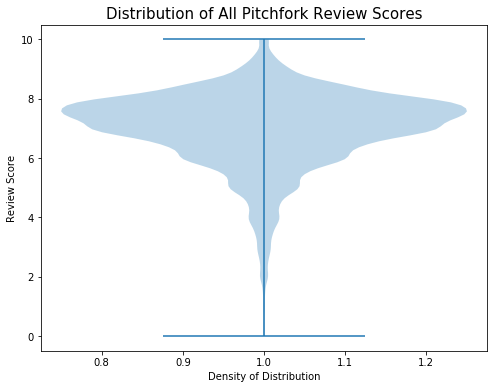

In [21]:
#show dispersion of pitchfork review overall
fig = plt.figure(figsize=(8,6))
plt.violinplot(pf_reviews_df['score'])
plt.title('Distribution of All Pitchfork Review Scores', fontsize=15)
plt.xlabel('Density of Distribution')
plt.ylabel('Review Score')
plt.show(fig)

### How do Pitchfork's review vary by genre?

In [50]:
#summarize each genre to a name and count of reviews
pf_bygenre_summarized = pf_reviews_df.groupby(['genre']).size()
#sort dataframe so columns are ranked
pf_bygenre_summarized.sort_values(ascending=False)

genre
rock            9438
electronic      3874
experimental    1815
rap             1559
pop/r&b         1432
metal            862
folk/country     685
jazz             435
global           219
dtype: int64

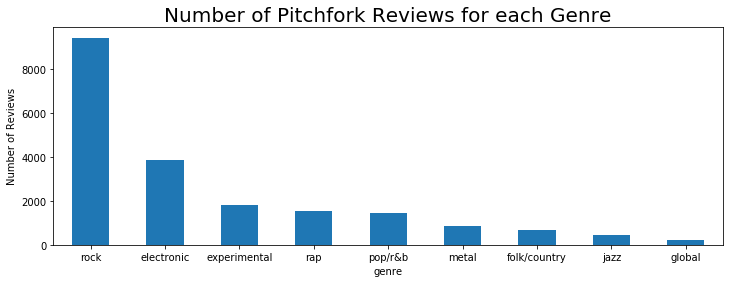

In [46]:
#plot the results
plt.figure(figsize=(12,4)) 
pf_bygenre_summarized.sort_values(ascending=False).plot.bar()
plt.title('Number of Pitchfork Reviews for each Genre', fontsize=20)
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

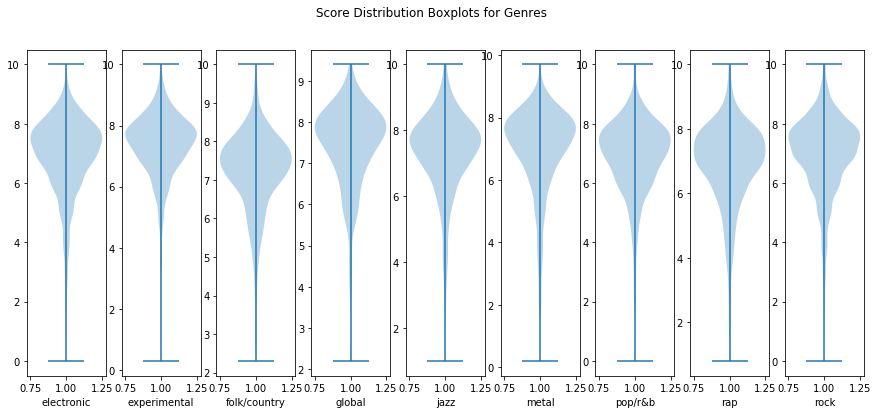

In [48]:
#plots of individual genre's score distribution
fig2 = plt.figure(figsize=(15,6))
plt.ylabel('Score')
plt.suptitle('Score Distribution Boxplots for Genres')

for genreno, genreiter in enumerate(pf_bygenre_df.itertuples(index=True)):
    genrei = genreiter.Index
    plt.subplot(1, len(pf_bygenre_df.index), genreno+1) #, sharex='col', sharey='row')
    genreset = pf_reviews_df[pf_reviews_df['genre'] == genrei]['score'] #get scores for genre
    plt.violinplot(genreset)
    plt.xlabel(genrei)

    
plt.show(fig2)    

In [55]:
#Genre standard deviations
genre_std = pf_reviews_df.groupby(['genre'])['score'].std()
genre_std.sort_values()

genre
global          1.006076
folk/country    1.064435
experimental    1.106455
jazz            1.251104
pop/r&b         1.295232
rap             1.302703
electronic      1.310056
rock            1.360347
metal           1.387799
Name: score, dtype: float64

Perhaps because of the focus on rock music, the standard deviation for rock albums is larger. This could be because of a different selection process or different reaction to that style. 

Pitchfork's focus is on rock music, and so I will look at rock compared to all other genres. 

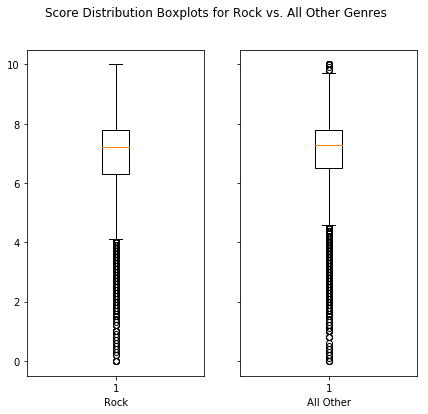

In [47]:
#plot Rock vs Other
fig3 = plt.figure(figsize=(7,6))
plt.ylabel('Score')
plt.suptitle('Score Distribution Boxplots for Rock vs. All Other Genres')

ax1 = plt.subplot(121)
plt.boxplot(pf_reviews_df[pf_reviews_df['genre'] == 'rock']['score'])
plt.xlabel('Rock')

ax2 = plt.subplot(122,  sharey=ax1)
plt.boxplot(pf_reviews_df[pf_reviews_df['genre'] != 'rock']['score'])
plt.xlabel('All Other')
plt.setp(ax2.get_yticklabels(), visible=False)
    
plt.show(fig3)    

### Comparison of Review Scores between Pitchfork and Fantano

In [26]:
#create low case Artist and Album name columns in both dataframes so they can be used to join Dataframes
fantano_reviewdf['artist_lc'] = fantano_reviewdf['artist'].str.lower()
fantano_reviewdf['title_lc'] = fantano_reviewdf['title'].str.lower()


In [27]:
# join Fantano and PF datasets
Fantano_PF_intersec_df = pd.merge(fantano_reviewdf, pf_reviews_df, 
                               left_on=['artist_lc','title_lc'], right_on=['artist','title'], 
                               how='inner', suffixes=('_Fantano', '_pf'))
# check data is correctly joined
Fantano_PF_intersec_df.head()



,Unnamed: 0,title_Fantano,artist_Fantano,review_date,review_type,score_Fantano,word_score,best_tracks,worst_track,link,artist_lc,title_lc,reviewid,title_pf,artist_pf,score_pf,best_new_music,genre
0,0,Cosmogramma,Flying Lotus,2010-05-05,Album,8.0,NaN,[],NaN,https://www.youtube.com/watch?v=KCuamde9Atc,flying lotus,cosmogramma,14198,cosmogramma,flying lotus,8.8,1,electronic
1,2,Latin,Holy Fuck,2010-05-10,Album,7.0,NaN,[],NaN,https://www.youtube.com/watch?v=ySXryTlo9Ac,holy fuck,latin,14207,latin,holy fuck,7.8,0,electronic
2,3,High Violet,The National,2010-05-11,Album,6.0,NaN,[],NaN,https://www.youtube.com/watch?v=DuMUDldrG3g,the national,high violet,14203,high violet,the national,8.7,1,rock
3,5,Together,The New Pornographers,2010-05-13,Album,7.0,NaN,[],NaN,https://www.youtube.com/watch?v=Lfw6vPZAUtc,the new pornographers,together,14195,together,the new pornographers,7.3,0,rock
4,6,Sea of Cowards,The Dead Weather,2010-05-16,Album,5.0,NaN,[],NaN,https://www.youtube.com/watch?v=v_7WlMvv50I,the dead weather,sea of cowards,14237,sea of cowards,the dead weather,7.8,0,rock


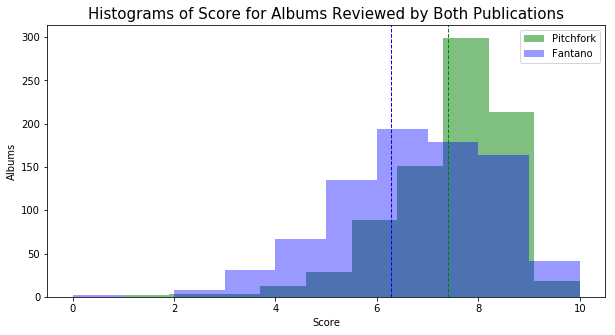

In [28]:
#plot histograms for review scores for mutually reviewed albums 
plt.figure(figsize=(10,5))
plt.hist(Fantano_PF_intersec_df['score_pf'], color='g', alpha=.5, label='Pitchfork', bins=10)
plt.axvline(Fantano_PF_intersec_df['score_pf'].mean(), color='g', linestyle='dashed', linewidth=1)

plt.hist(Fantano_PF_intersec_df['score_Fantano'], color='b', alpha=.4, label='Fantano', bins=10 )
plt.axvline(Fantano_PF_intersec_df['score_Fantano'].mean(), color='b', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('Score')
plt.ylabel('Albums')
plt.title('Histograms of Score for Albums Reviewed by Both Publications', fontsize=15)
plt.show()

The set of albums that both have reviewed are a sample of the population of albums each has reviewed. Thus, 
These are both negative-skewed distributions. This creates a problem for comparing the distributions, as the tests assume normality. I will review the standard deviations to see if that will affect the testing. 

We can also see the Fantano scores have a more narrowly clustered distribution, which should be apparent from the standard deviations. 

In [29]:
#find the standard deviation and 
PF_inter_score_std = np.std(Fantano_PF_intersec_df['score_pf'])
Fantano_inter_score_std = np.std(Fantano_PF_intersec_df['score_Fantano'])
print("The standard deviation for the PF scores is {} and the standard deviation for the Fantano scores is {}".format(PF_inter_score_std,Fantano_inter_score_std))

The standard deviation for the PF scores is 1.1687681849094667 and the standard deviation for the Fantano scores is 1.5853955816697904


In [30]:
#get basic stats for both sets of scores
Fantano_PF_intersec_df[['score_pf', 'score_Fantano']].describe()

,score_pf,score_Fantano
count,821.000000,821.000000
mean,7.407674,6.280146
std,1.169481,1.586362
min,1.000000,0.000000
25%,6.800000,5.000000
50%,7.600000,6.000000
75%,8.200000,7.000000
max,10.000000,10.000000


In [31]:
scipy.stats.ttest_ind(Fantano_PF_intersec_df['score_pf'], Fantano_PF_intersec_df['score_Fantano'])

Ttest_indResult(statistic=16.392540084192476, pvalue=4.816949713842482e-56)

The number of observations is quite large, so a t-test gives an approximation in this case. This p-value very small and should be considered significant. The Fantano scores are a bit over one unit (both reviewers use a unitles 10 point scale, 0 the worst and 10 being the best.)

Because of the skewness and difference in standard deviations, I chose also run a ranked sum test. 

From this we can conclude that the average score that Fantano gives to an album is significantly higher than the average score pitchfork would give to the same album. 

In [32]:
scipy.stats.ranksums(Fantano_PF_intersec_df['score_pf'], Fantano_PF_intersec_df['score_Fantano'])

RanksumsResult(statistic=15.690456762842059, pvalue=1.7578613331609182e-55)

The results produced are similar but give slightly lower confidence in the result. 

##### Interpretation:
The Fantano's higher scores can be interpreted to mean that he 'grades easier' than pitchfork. However, this assumes the sample of albums chosen to review is unbiased. There could be reasons this is not true:  
    * listening or partially listening to the album but not publishing a review if it one doesn't like it on first listen  
    * seeking out albums by bands one already likes, if albums quality has some consistancy for a given band  

### Distribution of the difference in score for each album
We might also want to know how similar the scores are for any individual album - do the two reviewers give scores that are similar, just with a somewhat higher average for Fantano? 

Let's visualize where the scores fall for each album between the two reviewers.

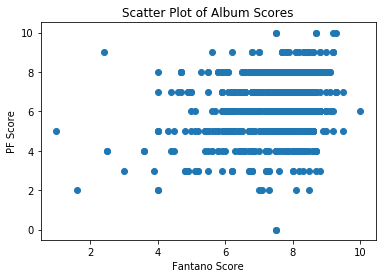

In [33]:
plt.scatter(Fantano_PF_intersec_df['score_pf'], Fantano_PF_intersec_df['score_Fantano'])
plt.xlabel('Fantano Score')
plt.ylabel('PF Score')
plt.title('Scatter Plot of Album Scores')
plt.show()

These look like they are spread out. How much does the score vary by for an typical album?

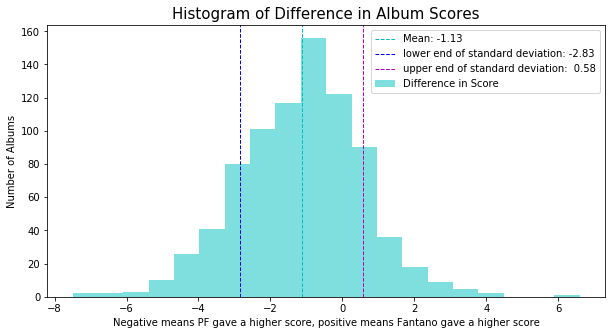

In [34]:
#create score diff df
score_diff_F_min_pf_df = Fantano_PF_intersec_df.loc[:,['artist_Fantano', 'title_Fantano']]
score_diff = Fantano_PF_intersec_df['score_Fantano'] - Fantano_PF_intersec_df['score_pf']
score_diff_F_min_pf_df['difference']= score_diff

#compute values for plot
diff_mean = score_diff_F_min_pf_df['difference'].mean()
diff_st = score_diff_F_min_pf_df['difference'].std()
diff_st_l = diff_mean - diff_st
diff_st_u = diff_mean + diff_st

#plot
plt.figure(figsize=(10,5))
plt.hist(score_diff_F_min_pf_df['difference'], color='c', alpha=.5, bins=20, label='Difference in Score')
plt.title('Histogram of Difference in Album Scores', fontsize= 15)
plt.xlabel('Negative means PF gave a higher score, positive means Fantano gave a higher score')
plt.ylabel('Number of Albums')
plt.axvline(diff_mean , color='c', linestyle='dashed', linewidth=1, label='Mean: {:5.2f}'.format(diff_mean))
plt.axvline(diff_mean - diff_st, color='b', linestyle='dashed', linewidth=1, 
            label='lower end of standard deviation: {:5.2f}'.format(diff_st_l))
plt.axvline(diff_mean + diff_st, color='m', linestyle='dashed', linewidth=1, 
            label='upper end of standard deviation: {:5.2f}'.format(diff_st_u))
plt.legend(loc='upper right')
plt.show()


Let's check this is noramlly distributed. 

In [35]:
#create normal distribution with same size as Best New Music
normal_diff = np.random.normal(40, .1, score_diff_F_min_pf_df['difference'].count())
normal_diff.sort()


In [36]:
differences = score_diff_F_min_pf_df['difference']
differences = differences.sort_values()

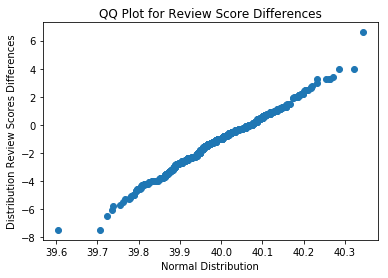

In [37]:
#plot normal distribution and Best New Music on QQ
plt.plot(normal_diff, differences, "o")
plt.xlabel('Normal Distribution')
plt.ylabel('Distribution Review Scores Differences')
plt.title('QQ Plot for Review Score Differences')
plt.show()

There are a couple of outliers, but this is close to normal.

### Pitchfork's 'Best New Music'

Pitchfork adds some of the albums that it reviews to an ongoing cumulative list call 'Best New Music'. Are the reviews scores for these albums higher than the average review? How much higher?

For this question, the reviews are considered as the population, since this is question comparing 

In [38]:
#slice best new music
pf_bnm = pf_reviews_df.loc[pf_reviews_df['best_new_music'] == 1]['score']


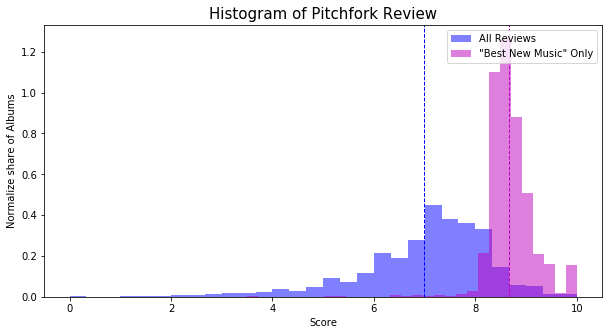

In [39]:
#plot results
plt.figure(figsize=(10,5))
plt.hist(pf_reviews_df['score'], color='b', alpha=.5, label='All Reviews', bins=30, density=True)
plt.axvline(pf_reviews_df['score'].mean(), color='b', linestyle='dashed', linewidth=1)

plt.hist(pf_bnm, color='m', alpha=.5, label='"Best New Music" Only', bins=30, density=True)
plt.axvline(pf_bnm.mean(), color='m', linestyle='dashed', linewidth=1)

plt.legend(loc='upper right')
plt.xlabel('Score')
plt.ylabel('Normalize share of Albums')
plt.title('Histogram of Pitchfork Review', fontsize=15)
plt.show()

As described above, the distribution of all reviews appears skewed. The Best New Music scores, while having a much higher mean, is a sample of all reviews and appears to be closer to normal. To test this, we will look at a Quantile-Quantile plot.

In [40]:
#create normal distribution with same size as Best New Music
normal = np.random.normal(40, .1, 1132)

#sort bnm values
pf_bnm = pf_bnm.sort_values()
normal.sort()

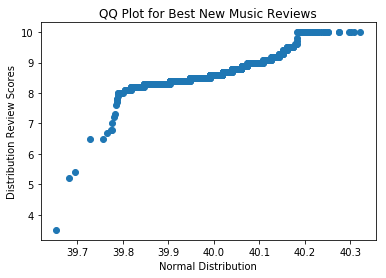

In [41]:
#plot normal distribution and Best New Music on QQ
plt.plot(normal, pf_bnm, "o")
plt.xlabel('Normal Distribution')
plt.ylabel('Distribution Review Scores')
plt.title('QQ Plot for Best New Music Reviews')
plt.show()

There is some differences, especially at the extreme ends of the distribution - a very few low scores, and a grouping of perfect 10 scores at the high end. This is likely due to the bounds of the scores - low scores in 'best new music' are contrary to the definition of 'Best' and very rare, and this tail is thin, until around a score of 8. The maximum score of 10 puts a hard limit on the right tail, limiting . 

## Proposal for Additional Research